In [79]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import libpysal
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from itertools import product

# Read the CSV file
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", 
           "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", 
           "hours-per-week", "native-country", "income"]

df = pd.read_csv("adult.csv", names=columns, skipinitialspace=True)


In [80]:
# Replace "?" with NaN
df.replace('?', np.nan, inplace=True)

# Remove those duplicates
df.drop_duplicates(inplace=True)

# Fill NaN values with a blank space for categorical columns now!
categorical_columns = ['workclass', 'occupation', 'native-country']
df[categorical_columns] = df[categorical_columns].fillna('')

# Remove rows with blank occupations please
df = df[df['occupation'] != '']


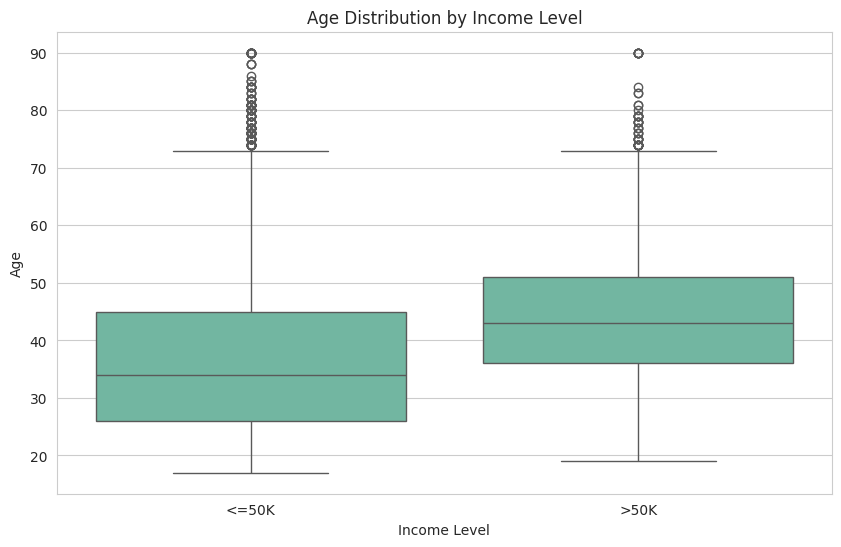

In [81]:
# 1. Box-and-Whisker Plot for Age Distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x='income', y='age', data=df)
plt.title('Age Distribution by Income Level')
plt.xlabel('Income Level')
plt.ylabel('Age')
plt.show()

/tmp/ipykernel_408706/360242686.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data_le50k = df.groupby(['age_group', 'education'])['income'].apply(lambda x: (x == '<=50K').mean() * 100).unstack()


<Figure size 1600x1000 with 0 Axes>

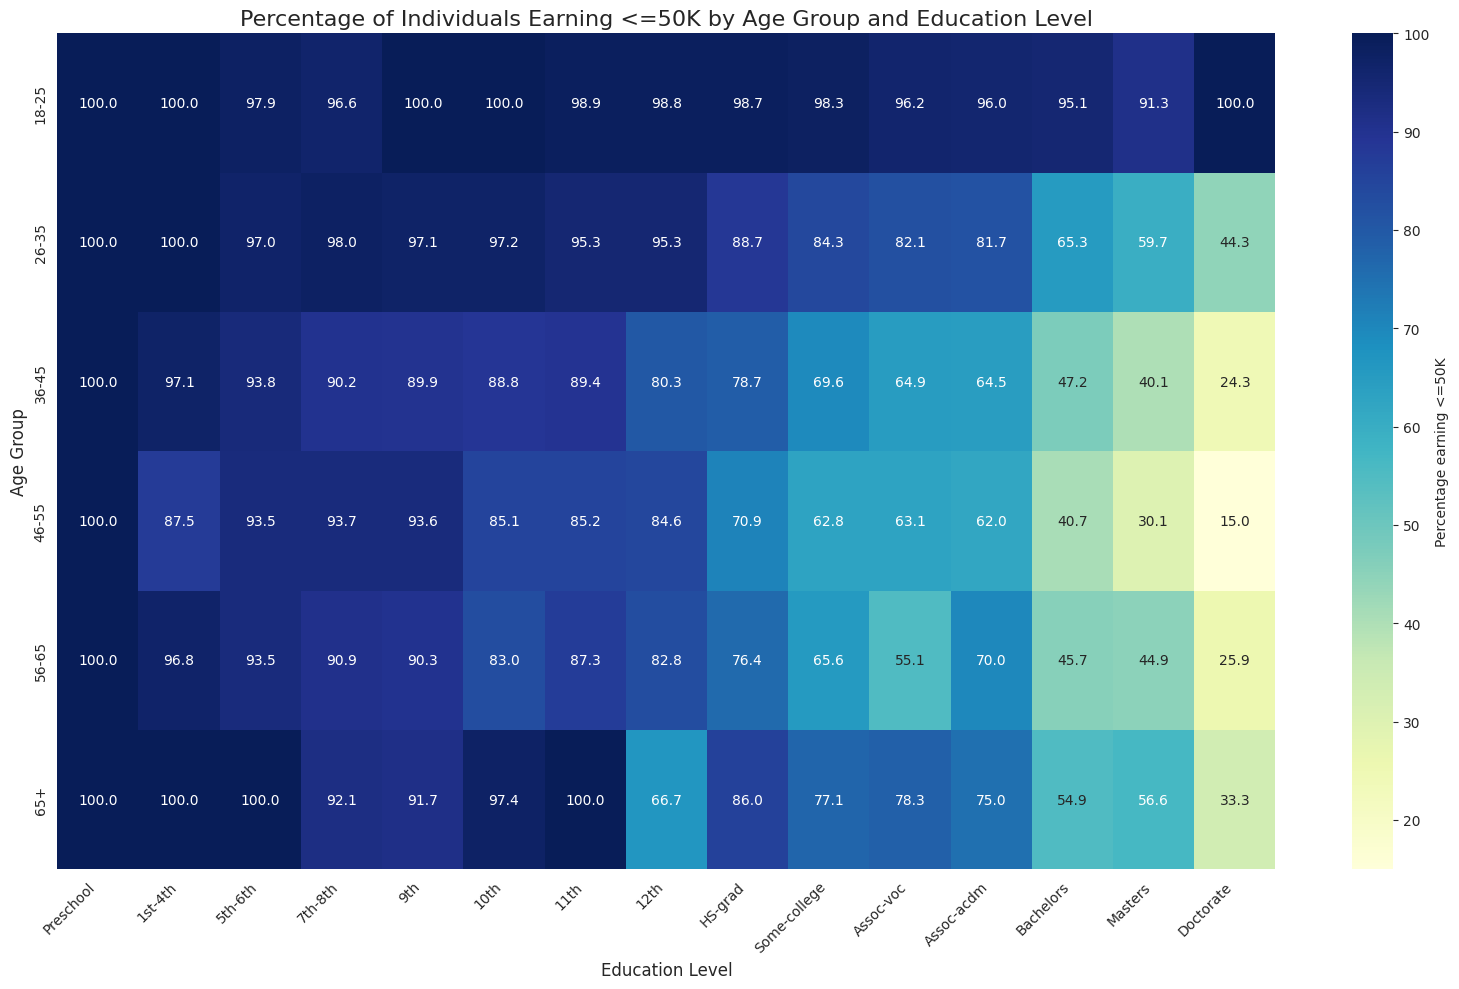

Average percentage earning <=50K by education level:
education
Preschool       100.000000
1st-4th          96.888836
5th-6th          95.952473
9th              93.760781
7th-8th          93.569834
11th             92.680068
10th             91.907304
12th             84.751098
HS-grad          83.243096
Some-college     76.287147
Assoc-acdm       74.870153
Assoc-voc        73.266501
Bachelors        58.149487
Masters          53.786620
Doctorate        40.464929
dtype: float64

Average percentage earning <=50K by age group:
age_group
18-25    97.856498
26-35    85.725589
65+      80.600183
36-45    74.593280
56-65    73.876002
46-55    71.179778
dtype: float64


In [82]:
# Data prep for Heatmap (<=50K group)
plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")

# Create those age groups
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 45, 55, 65, 100], labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])

# Calculate percentage earning <=50K for each age-education combination using math
heatmap_data_le50k = df.groupby(['age_group', 'education'])['income'].apply(lambda x: (x == '<=50K').mean() * 100).unstack()

# Sort education levels by tiers of education
education_order = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Doctorate']
heatmap_data_le50k = heatmap_data_le50k.reindex(columns=education_order)

# Create heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data_le50k, annot=True, fmt='.1f', cmap='YlGnBu', cbar_kws={'label': 'Percentage earning <=50K'})

plt.title('Percentage of Individuals Earning <=50K by Age Group and Education Level', fontsize=16)
plt.xlabel('Education Level', fontsize=12)
plt.ylabel('Age Group', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display some statistics
print("Average percentage earning <=50K by education level:")
print(heatmap_data_le50k.mean().sort_values(ascending=False))

print("\nAverage percentage earning <=50K by age group:")
print(heatmap_data_le50k.mean(axis=1).sort_values(ascending=False))

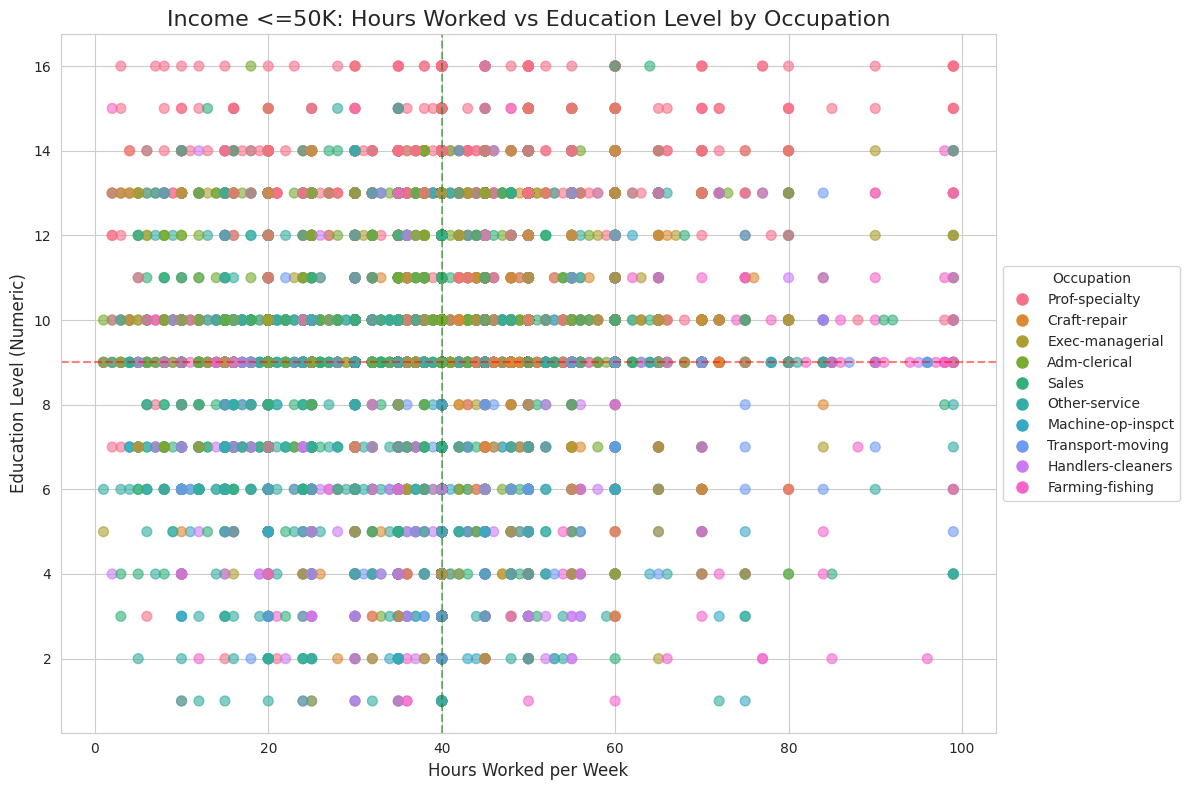

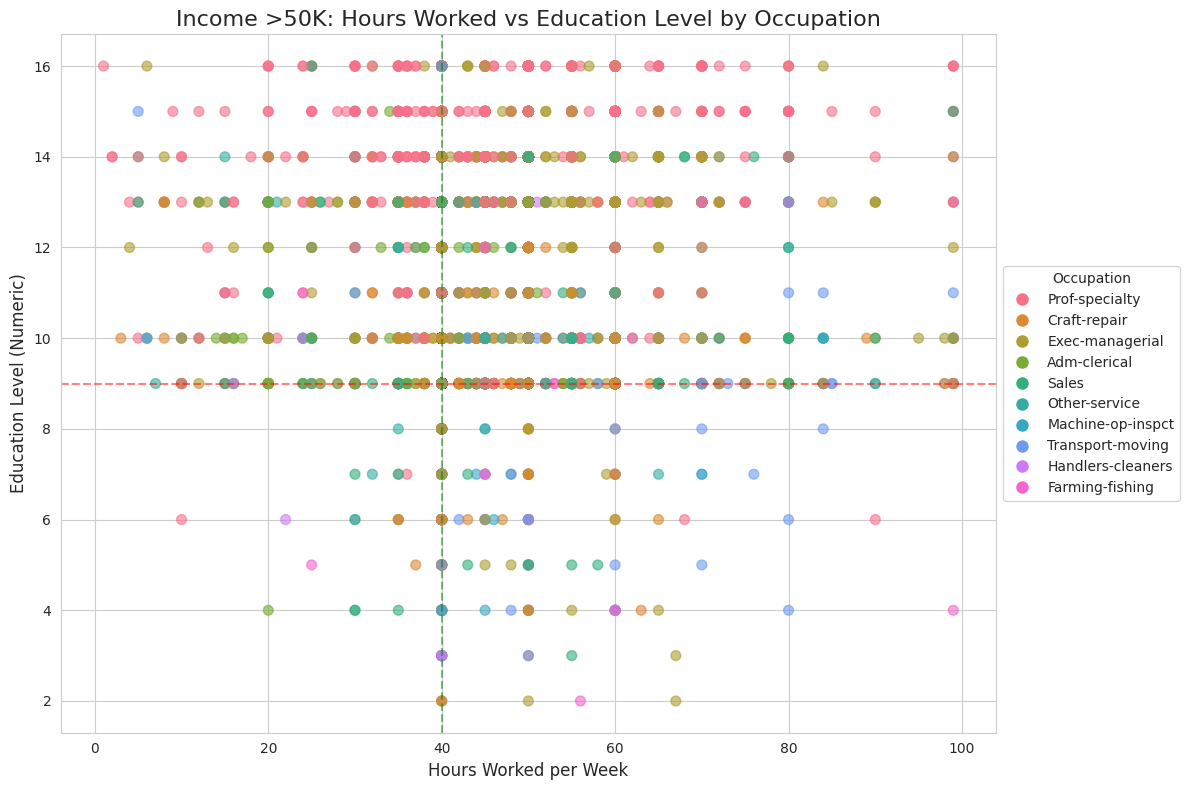


Statistics for income group: <=50K
Average hours worked per week by occupation:
occupation
Farming-fishing      46.047891
Transport-moving     43.624902
Exec-managerial      42.816881
Craft-repair         41.609795
Machine-op-inspct    40.383781
Prof-specialty       40.117208
Sales                38.329959
Handlers-cleaners    37.613406
Adm-clerical         37.039865
Other-service        34.342105
Name: hours-per-week, dtype: float64

Average education level by occupation:
occupation
Prof-specialty       12.378402
Exec-managerial      10.839294
Adm-clerical         10.016559
Sales                 9.904012
Craft-repair          8.910900
Other-service         8.716233
Transport-moving      8.653093
Handlers-cleaners     8.457521
Farming-fishing       8.433295
Machine-op-inspct     8.362079
Name: education-num, dtype: float64

Percentage of individuals in each occupation:
occupation
Adm-clerical         14.951857
Craft-repair         14.511692
Other-service        14.461256
Sales        

In [83]:
# Data preparation for the Scatter Plots
sns.set_style("whitegrid")

# Select those top N occupations by frequency
N = 10  # You can adjust this number
top_occupations = df['occupation'].value_counts().nlargest(N).index

# Filter the dataframe to include only those top top occupations
df_top = df[df['occupation'].isin(top_occupations)]

# Create a copy of the dataframe for this specific plot to not mess with the original
df_cleaned = df_top.copy()

# Remove rows with blank occupations in the copied dataframe
df_cleaned = df_cleaned[df_cleaned['occupation'] != '']

# Update the top occupations based on the cleaned data 
top_occupations_cleaned = df_cleaned['occupation'].value_counts().index

# Create a categorical color map for all those cleaned occupations
color_map_cleaned = dict(zip(top_occupations_cleaned, sns.color_palette("husl", n_colors=len(top_occupations_cleaned))))

# Function to create scatter plot
def create_scatter(data, title):
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(data['hours-per-week'], 
                          data['education-num'], 
                          c=data['occupation'].map(color_map_cleaned), 
                          alpha=0.6,
                          s=50)
    
    plt.title(title, fontsize=16)
    plt.xlabel('Hours Worked per Week', fontsize=12)
    plt.ylabel('Education Level (Numeric)', fontsize=12)
    
    # Add a horizontal line at education-num = 9 (approx high school level)
    plt.axhline(y=9, color='r', linestyle='--', alpha=0.5)
    
    # Add a vertical line at 40 hours per week, if only this was 30...
    plt.axvline(x=40, color='g', linestyle='--', alpha=0.5)
    
    # Create the legend of legends
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=occupation, 
                       markerfacecolor=color, markersize=10) 
                       for occupation, color in color_map_cleaned.items()]
    plt.legend(handles=legend_elements, title="Occupation", loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.show()

# Create scatter plot for <=50K
create_scatter(df_cleaned[df_cleaned['income'] == '<=50K'], 'Income <=50K: Hours Worked vs Education Level by Occupation')

# Create scatter plot for >50K
create_scatter(df_cleaned[df_cleaned['income'] == '>50K'], 'Income >50K: Hours Worked vs Education Level by Occupation')

# Display some statistics
for income_group in ['<=50K', '>50K']:
    df_income = df_cleaned[df_cleaned['income'] == income_group]
    
    print(f"\nStatistics for income group: {income_group}")
    
    print("Average hours worked per week by occupation:")
    avg_hours = df_income.groupby('occupation')['hours-per-week'].mean().sort_values(ascending=False)
    print(avg_hours)

    print("\nAverage education level by occupation:")
    avg_education = df_income.groupby('occupation')['education-num'].mean().sort_values(ascending=False)
    print(avg_education)

    print("\nPercentage of individuals in each occupation:")
    occupation_percentages = df_income['occupation'].value_counts(normalize=True) * 100
    print(occupation_percentages.sort_values(ascending=False))

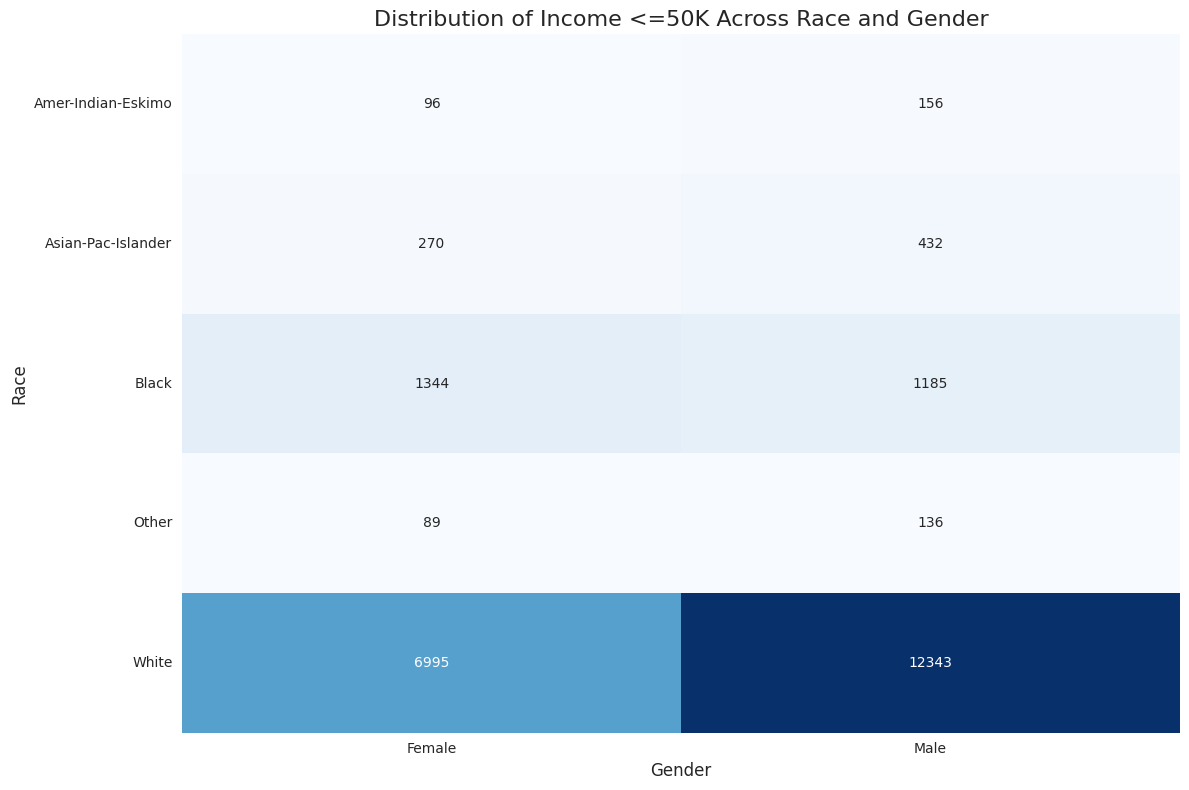

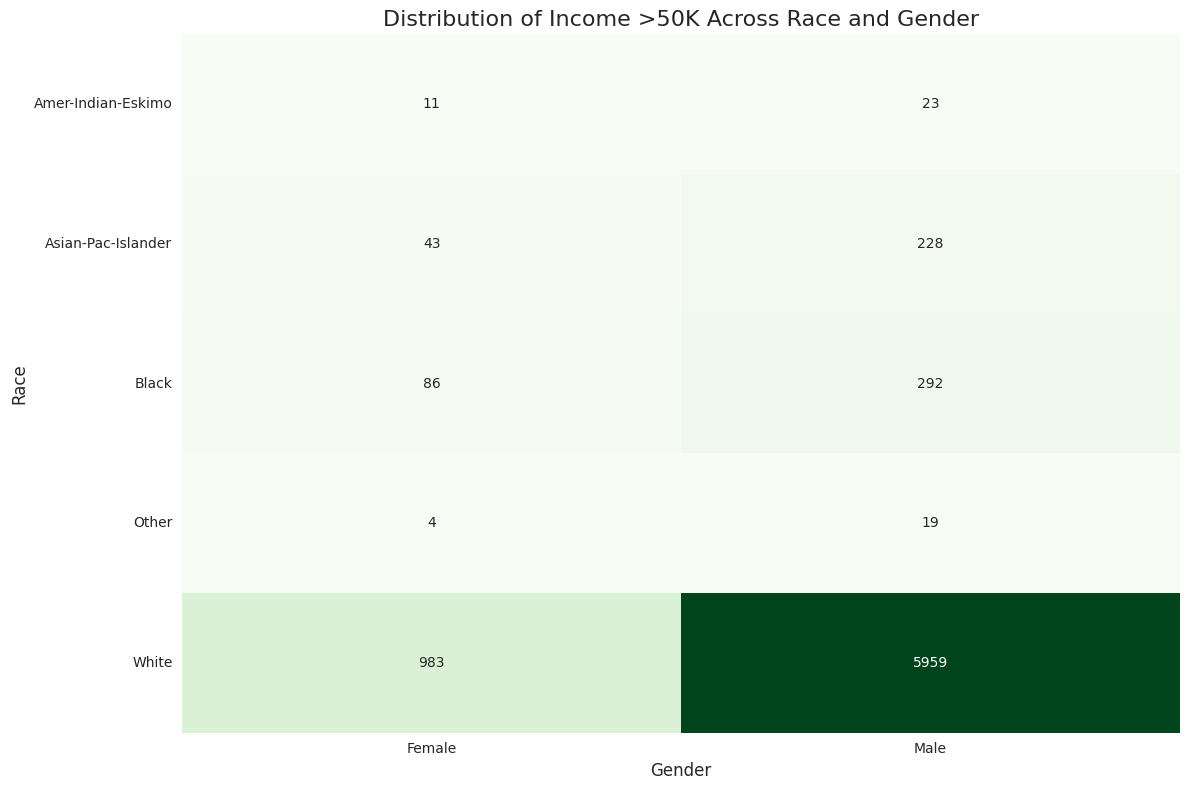

Percentage of individuals earning >$50K by race and gender:
sex                    Female       Male
race                                    
Amer-Indian-Eskimo  10.280374  12.849162
Asian-Pac-Islander  13.738019  34.545455
Black                6.013986  19.769804
Other                4.301075  12.258065
White               12.321384  32.559283

Total count of individuals by race and gender:
sex                 Female   Male
race                             
Amer-Indian-Eskimo     107    179
Asian-Pac-Islander     313    660
Black                 1430   1477
Other                   93    155
White                 7978  18302


In [84]:
# Prepare data for heatmaps
heatmap_data_le50k = df[df['income'] == '<=50K'].groupby(['race', 'sex']).size().unstack(fill_value=0)
heatmap_data_gt50k = df[df['income'] == '>50K'].groupby(['race', 'sex']).size().unstack(fill_value=0)

# Plot heatmap for <=50K income group
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_le50k, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Distribution of Income <=50K Across Race and Gender', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Race', fontsize=12)
plt.tight_layout()
plt.show()

# Heating up the heatmap for >50K income group
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_gt50k, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Distribution of Income >50K Across Race and Gender', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Race', fontsize=12)
plt.tight_layout()
plt.show()

# Display some statistics
print("Percentage of individuals earning >$50K by race and gender:")
income_by_race_gender = df.groupby(['race', 'sex'])['income'].apply(lambda x: (x == '>50K').mean() * 100).unstack()
print(income_by_race_gender)

print("\nTotal count of individuals by race and gender:")
count_by_race_gender = df.groupby(['race', 'sex']).size().unstack()
print(count_by_race_gender)

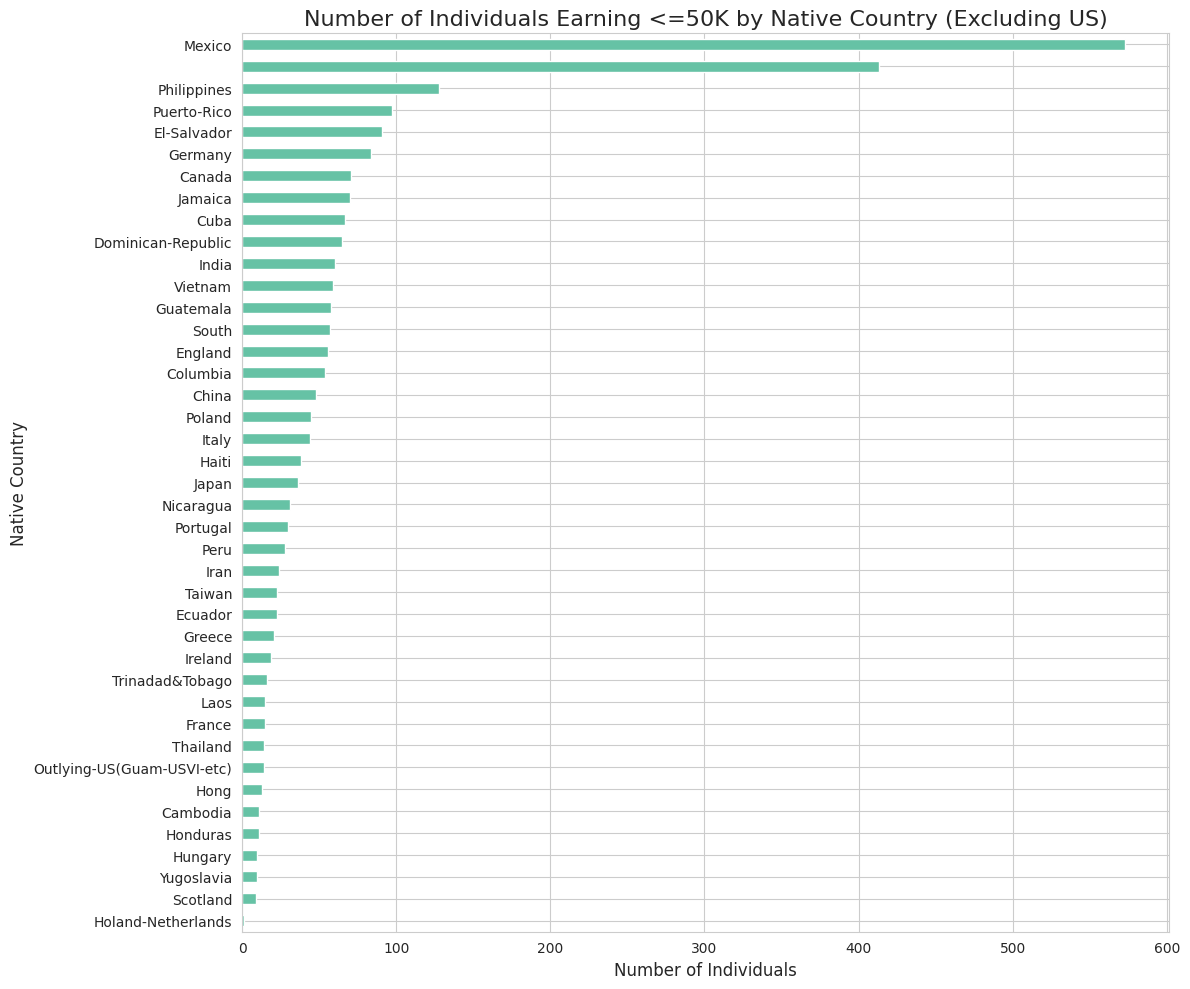

Top 10 countries (excluding US) with the most individuals earning <=50K:
native-country
Mexico                573
                      413
Philippines           128
Puerto-Rico            97
El-Salvador            91
Germany                84
Canada                 71
Jamaica                70
Cuba                   67
Dominican-Republic     65
dtype: int64

Percentage of individuals earning <=50K by native country:
native-country
Outlying-US(Guam-USVI-etc)    100.000000
Holand-Netherlands            100.000000
Dominican-Republic             97.014925
Columbia                       96.428571
Guatemala                      95.081967
Mexico                         94.554455
Nicaragua                      93.939394
Peru                           93.333333
Vietnam                        92.187500
Honduras                       91.666667
El-Salvador                    91.000000
Haiti                          90.476190
Puerto-Rico                    88.990826
Trinadad&Tobago                

In [85]:
# Data preparation for native country analysis
country_income = df[df['income'] == '<=50K'].groupby('native-country').size().sort_values(ascending=True)

# Remove 'United-States' from the data to focus on international countries cause we need some diversity
country_income = country_income[country_income.index != 'United-States']

# Create the best bar chart
plt.figure(figsize=(12, 10))
country_income.plot(kind='barh')
plt.title('Number of Individuals Earning <=50K by Native Country (Excluding US)', fontsize=16)
plt.xlabel('Number of Individuals', fontsize=12)
plt.ylabel('Native Country', fontsize=12)
plt.tight_layout()
plt.show()

# Display some statistics
print("Top 10 countries (excluding US) with the most individuals earning <=50K:")
print(country_income.nlargest(10))

print("\nPercentage of individuals earning <=50K by native country:")
country_percentage = df.groupby('native-country')['income'].apply(lambda x: (x == '<=50K').mean() * 100).sort_values(ascending=False)
print(country_percentage)

# Calculate and print the total number of international students
total_international = df[df['native-country'] != 'United-States'].shape[0]
international_le50k = df[(df['native-country'] != 'United-States') & (df['income'] == '<=50K')].shape[0]
print(f"\nTotal number of international individuals: {total_international}")
print(f"Number of international individuals earning <=50K: {international_le50k}")
print(f"Percentage of international individuals earning <=50K: {(international_le50k/total_international)*100:.2f}%")